1) Try a Support Vector Machine regressor (sklearn.svm.SVR) with
various hyperparameters, such as kernel="linear" (with various
values for the C hyperparameter) or kernel="rbf" (with various values
for the C and gamma hyperparameters). Don’t worry about what these
hyperparameters mean for now. How does the best SVR predictor
perform?

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("insurance.csv")

insurance = df.drop("region", axis=1) # drop labels for training set
insurance = insurance.drop("sex", axis=1)
insurance = insurance.drop("smoker", axis=1)
insurance = insurance.drop("age", axis=1)

attributes = ['bmi', 'children', 'charges']

labels = df["age"].copy()

print(insurance)
print(labels)


         bmi  children      charges
0     27.900         0  16884.92400
1     33.770         1   1725.55230
2     33.000         3   4449.46200
3     22.705         0  21984.47061
4     28.880         0   3866.85520
...      ...       ...          ...
1333  30.970         3  10600.54830
1334  31.920         0   2205.98080
1335  36.850         0   1629.83350
1336  25.800         0   2007.94500
1337  29.070         0  29141.36030

[1338 rows x 3 columns]
0       19
1       18
2       28
3       33
4       32
        ..
1333    50
1334    18
1335    18
1336    21
1337    61
Name: age, Length: 1338, dtype: int64


In [2]:
param_grid = [
        {'kernel': ['linear'], 'C': [10.]},
        {'kernel': ['rbf'], 'C': [1.0],
         'gamma': [0.01]},
    ]

svm_reg = SVR()

In [3]:
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(insurance, labels)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..............................C=10.0, kernel=linear; total time= 1.7min
[CV] END ..............................C=10.0, kernel=linear; total time= 3.9min
[CV] END ..............................C=10.0, kernel=linear; total time= 3.4min
[CV] END ..............................C=10.0, kernel=linear; total time= 4.5min
[CV] END ..............................C=10.0, kernel=linear; total time= 3.4min
[CV] END ......................C=1.0, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.0, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.0, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.0, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.0, gamma=0.01, kernel=rbf; total time=   0.1s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0], 'kernel': ['linear']},
                         {'C': [1.0], 'gamma': [0.01], 'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [4]:
grid_search.best_params_

{'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}

2. Try replacing GridSearchCV with RandomizedSearchCV

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal



# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=2, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(insurance, labels)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time= 1.3min
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time= 3.6min
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time= 1.7min
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time= 2.1min
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time= 3.7min
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   0.1s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   0.1s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   0.1s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   0.1s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   0.1s


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=2,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A730C2CA50>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A730AB2450>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

13.456386452306555
{'C': 26290.20646430022, 'gamma': 0.9084469696321253, 'kernel': 'rbf'}


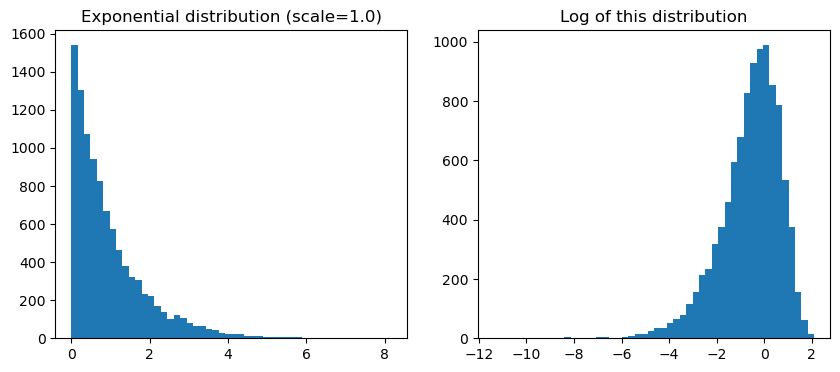

In [6]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)
print(rnd_search.best_params_)
expon_distrib = expon(scale=1.)

samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

3)Try adding a transformer in the preparation pipeline to select only the
most important attributes.


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(insurance)
cat_attribs = ["sex"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

insurance_tf = full_pipeline.fit_transform(df)
print(insurance_tf)
print(insurance_tf.shape)
print(labels.shape)

[[-0.45332    -0.90861367  0.2985838   1.          0.        ]
 [ 0.5096211  -0.07876719 -0.95368917  0.          1.        ]
 [ 0.38330685  1.58092576 -0.72867467  0.          1.        ]
 ...
 [ 1.0148781  -0.90861367 -0.96159623  1.          0.        ]
 [-0.79781341 -0.90861367 -0.93036151  1.          0.        ]
 [-0.26138796 -0.90861367  1.31105347  1.          0.        ]]
(1338, 5)
(1338,)


In [8]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4 ]},
  ]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(insurance_tf, labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4],
                          'n_estimators': [3, 10, 30, 50]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [10]:
k = 2

In [11]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.10482885, 0.03959714, 0.84482722, 0.0047063 , 0.00604049])

In [12]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([0, 2], dtype=int64)

In [13]:
np.array(attributes)[top_k_feature_indices]

array(['bmi', 'charges'], dtype='<U8')

In [14]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.8448272197211486, 'charges'), (0.10482884525993336, 'bmi')]

In [15]:

preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

insurance_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(df)

insurance_prepared_top_k_features[0:3]

NameError: name 'insurance_prepared_top_k_features' is not defined

In [ ]:
insurance_tf[0:3, top_k_feature_indices]

4. Try creating a single pipeline that does the full data preparation plus the
final prediction.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

prepare_select_and_predict_pipeline.fit(df, labels)

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(df))

5. Automatically explore some preparation options using GridSearchCV

In [ ]:
full_pipeline.named_transformers_["cat"].handle_unknown = 'ignore'

param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(df, labels)

grid_search_prep.best_params_